In [4]:
using DiffusionMLE, Plots, PyCall, CSV, DataFrames, HDF5

# Introduction

This is a minimal example on how to apply our maximum likelihood estimator to a set of heterogeneous single-particle tracking data.  Here, "heterogeneous" refers to the fact that the data originate from subpopulations with differing diffusion coefficients.  

The code relevant for the analysis of heterogeneous data exploits threading, so it is recommended to run the command <code>export JULIA_NUM_THREADS=n</code>, with <code>n</code> being the number of available (physical) cores, before launching Julia.  This speeds up the numerics significantly.  

For more details on the theoretical framework, please refer to the associated preprint:
> J. T. Bullerjahn and G. Hummer, "Maximum likelihood estimates of diffusion coefficients from single-molecule tracking experiments", https://arxiv.org/abs/2011.09955

# Generate trajectories

Each trajectory can be seen as a $d$-dimensional array (<code>Array{Float64,2}</code>), so the data set should be of the type <code>Array{Array{Float64,2},1}</code>.  

Here, we generate mock data, made up of $M$ $d$-dimensional trajectories of different lengths $N = \{N_{1}, N_{2}, \dots, N_{M}\}$.  The $N_{i}$ are distributed uniformly on the interval $[3,100]$.  The data form a $3:4:3$-mixture of trajectories generated using three distinct diffusive dynamics.  

In [5]:
include("smeared_trajectory_integrator.jl")

const M = 1000 # Number of trajectories
const d = 2 # Dimension of trajectories

const N_sub = 10 # Number of substeps over which the trajectory is smeared out

N = [ rand(150:150) for i = 1 : M ] # Array of trajectory lengths

const a2_1 = 0.5
const a2_2 = 2.0
const a2_3 = 1.0
const σ2_1 = 0.1
const σ2_2 = 1.0
const σ2_3 = 10.0

B = [1/6 for m = 1 : M] # Array of blurring coefficients, where we have assumed a uniform illumination profile
data = vcat([make_2D_data(N[1:300],N_sub,a2_1,σ2_1), 
        make_2D_data(N[301:700],N_sub,a2_2,σ2_2), 
        make_2D_data(N[701:1000],N_sub,a2_3,σ2_3)]...); # Mock data set

# Analyzing the data

In [6]:
function print_results(estimates,uncertainties)
    K = size(estimates,2)
    for k = 1 : K
        println(string("a2_", k, " = ", estimates[1,k], " ± ", uncertainties[1,k]))
    end
    for k = 1 : K
        println(string("σ2_", k, " = ", estimates[2,k], " ± ", uncertainties[2,k]))
    end
    for k = 1 : K
        println(string("P_", k, " = ", estimates[3,k]))
    end
end

const N_local = 5000 # Max number of expectation-maximization cycles
const N_global = 1000 # Number of iterations with different initial parameters

# Ranges from which the initial values for the parameters are drawn:
a2_range = [ 0.001, 1000. ]
σ2_range = [ 0.001, 1000. ];

### Available cores for threading

In [7]:
using Base.Threads
println(string("Number of available cores for threading: ", nthreads()))

Number of available cores for threading: 1


### Assuming a single population

Estimates:
a2_1 = 1.2619599902691365 ± 0.009339819213426154
σ2_1 = 3.441930610814951 ± 0.01559631778086762
P_1 = 1.0

Kuiper statistic:
κ = 30.29547886350708


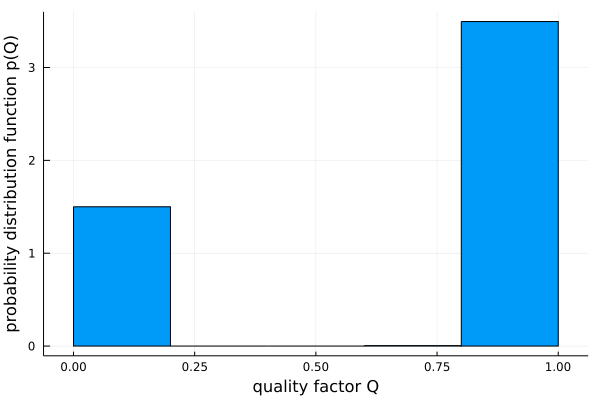


(process:18356): GLib-GIO-WARNING **: 11:51:55.322: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


In [8]:
parameters = MLE_estimator(B,data)
parameter_matrix = reshape(vcat([parameters,[1.0]]...), 3, 1)
P1_estimates, P1_L, P1_T = local_EM_estimator!(d,M,1,N_local,parameter_matrix,B,data)
P1_uncertainties = MLE_errors(B,data,parameters)

println("Estimates:")
print_results(P1_estimates,P1_uncertainties)

Q_sub = subpopulation_analysis(P1_T,P1_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("κ = ",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, 
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The distribution of quality factors, which should be uniform, and the associated Kuiper statistic reveal that a single-population model does not suffice.  

### Assuming two subpopulations

In [22]:
P2_estimates, P2_L, P2_T = global_EM_estimator(2,N_local,N_global,a2_range,σ2_range,B,data);

Progress:  26%|███████████                              |  ETA: 0:05:37

In [ ]:
P2_T

2×100 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5  0.5  0.5

In [17]:
B_sub, X_sub = sort_trajectories(2,P2_T,B,data)
P2_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P2_estimates[1:2,k]) for k = 1 : 2 ]...)

println("Estimates:")
print_results(P2_estimates,P2_uncertainties)

Q_sub = subpopulation_analysis(P2_T,P2_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, bins=10,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

LoadError: BoundsError: attempt to access 0-element Vector{Matrix{Float64}} at index [1]

The Kuiper statistic is slightly better, but overall a two-population model cannot explain the data.  

### Assuming three subpopulations

In [9]:
P3_estimates, P3_L, P3_T = global_EM_estimator(3,N_local,N_global,a2_range,σ2_range,B,data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


In [10]:
B_sub, X_sub = sort_trajectories(3,P3_T,B,data)
P3_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P3_estimates[1:2,k]) for k = 1 : 3 ]...)

println("Estimates:")
print_results(P3_estimates,P3_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P3_T,P3_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

LoadError: BoundsError: attempt to access 0-element Vector{Matrix{Float64}} at index [1]

The quality factors are uniformly distributed, and the Kuiper statistic evaluates close to unity for the three-population model.  

### Diffusion coefficients

Diffusion coefficients can be extracted from the $\sigma^2$-values, irrespective of the dimension $d$, as follows:
\begin{equation*}
D = \frac{\sigma^2}{2 \Delta t} \, .  
\end{equation*}
Here, $\sigma$ has the same dimension as the data, i.e., if the trajectories are recorded on the nanometer scale then $[\sigma] = \textrm{nm}$, and $\Delta t$ denotes the time step between two observations.  

### Assuming four subpopulations

In [11]:
P4_estimates, P4_L, P4_T = global_EM_estimator(4,N_local,N_global,a2_range,σ2_range,B,data);

┌ Warning: Failed to converge within 1000 iterations
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:185
┌ Warning: Failed to converge within 1000 iterations
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:185
Progress:   1%|█                                        |  ETA: 7:25:08┌ Warning: Failed to converge within 1000 iterations
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:185
Progress:   2%|█                                        |  ETA: 7:22:23┌ Warning: Failed to converge within 1000 iterations
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:185
Progress:   2%|█                                        |  ETA: 7:20:13┌ Warning: Failed to converge within 1000 iterations
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\

In [ ]:
B_sub, X_sub = sort_trajectories(4,P4_T,B,data)
P4_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P4_estimates[1:2,k]) for k = 1 : 4 ]...)

println("Estimates:")
print_results(P4_estimates,P4_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P4_T,P4_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

# Assuming 5 subpops

In [ ]:
P6_estimates, P6_L, P6_T = global_EM_estimator(6,N_local,N_global,a2_range,σ2_range,B,data);

In [ ]:
B_sub, X_sub = sort_trajectories(5,P5_T,B,data)
P5_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P4_estimates[1:2,k]) for k = 1 : 5 ]...)

println("Estimates:")
print_results(P5_estimates,P5_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P5_T,P5_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

# Below: Upload tdTomato_37Degree Mobile data

In [9]:
# Loads the first 100 frames of a trajectory for processing
function load_100traj_csv(raw_csv_file_path)
    csv_data = CSV.read(raw_csv_file_path, DataFrame)
    csv_data = dropmissing(csv_data)
    # Get just the first 100 frames of each track
    csv_data = csv_data[csv_data.Frame .< 101, :]
    # Get the first 100 trajectories
    csv_data = csv_data[csv_data.ID .< 100, :]
    trackIDs = unique(csv_data, :ID).ID
    trk_count = length(trackIDs)
    println(trk_count)
    B_values = [1/6 for m = 1 : trk_count]
    sing_cond_tracks = Array{Array{Float64,2},1}(undef, trk_count)
    n = 0
    for i in trackIDs
        n += 1
        indiv_track = csv_data[in([i]).(csv_data.ID), :]
        sing_cond_tracks[n] = Array(indiv_track[:, [:X, :Y]])
    end
    return sing_cond_tracks, B_values
end

load_100traj_csv (generic function with 1 method)

In [10]:
# Import some test trajectories...
tester = raw"C:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\Trajectory_CSVs\tdTomato_Mobile\tdTomato_37Degree_mobile.csv"
test_data = CSV.read(tester, DataFrame);

# Select just the tracks that have been re-zeroed
test_data = test_data[test_data.Frame .< 101, :]

# trackIDs = unique(test_data, :ID).ID;

In [11]:
mob_data, B_values = load_100traj_csv(tester);

100


In [38]:
PX_estimates, PX_L, PX_T = global_EM_estimator(4,N_local,N_global,a2_range,σ2_range,B_values,mob_data);

┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ Diffus

Estimates:
a2_1 = 0.0005974307957600005 ± 5.6623014970051847e-5
a2_2 = 0.002769012665816276 ± 0.00015174562457132104
a2_3 = 0.0026398386447414467 ± 8.470945657445727e-5
a2_4 = 0.002144885586228411 ± 9.459780298330547e-5
σ2_1 = 0.0005784862950782191 ± 5.889653063156527e-5
σ2_2 = 0.008539427911634513 ± 0.00026518982922960223
σ2_3 = 0.004035454509977016 ± 0.00011050728975474176
σ2_4 = 0.0014024175206089808 ± 7.950562380307624e-5
P_1 = 0.04000025401056942
P_2 = 0.3372035251876808
P_3 = 0.47476917280714326
P_4 = 0.14802704799460664


Kuiper statistic:
K=3.569714031454393


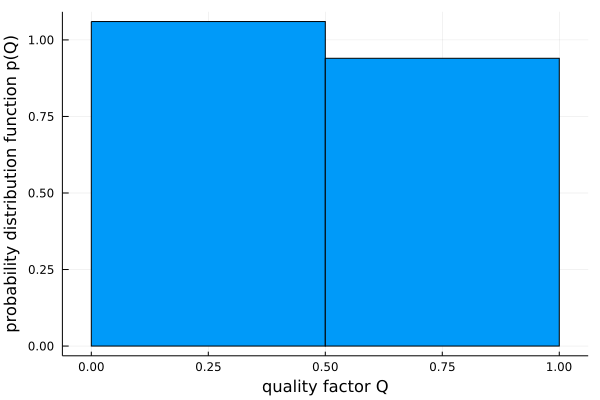

In [29]:
B_sub, X_sub = sort_trajectories(4,PX_T,B_values,mob_data)
PX_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], PX_estimates[1:2,k]) for k = 1 : 4 ]...)

println("Estimates:")
print_results(PX_estimates,PX_uncertainties)

println()

Q_sub = subpopulation_analysis(PX_T,PX_estimates,B_values,mob_data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

In [36]:
PX_estimates, PX_L, PX_T = global_EM_estimator(7,N_local,N_global,a2_range,σ2_range,B_values,mob_data);

┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ Diffus

Estimates:
a2_1 = 0.0005974246668731974 ± 5.662263130471992e-5
a2_2 = 0.0020828413333579196 ± 0.00011823188656384016
a2_3 = 0.0026801989636616726 ± 0.00018240094871425894
a2_4 = 0.004010858548337906 ± 0.00016883353681355616
a2_5 = 0.002170757848430973 ± 0.0001656712879549611
a2_6 = 0.0028123896633813015 ± 0.00012376930328443413
a2_7 = 0.0011985925246765718 ± 0.00011007832927115754
σ2_1 = 0.0005784868340370713 ± 5.8896476164654615e-5
σ2_2 = 0.001635086147432447 ± 0.00010995123017103585
σ2_3 = 0.009448079120323772 ± 0.000334144468991268
σ2_4 = 0.002105033796044048 ± 0.00012516322224377625
σ2_5 = 0.0003746230465869343 ± 6.185921130990599e-5
σ2_6 = 0.005304675381626386 ± 0.00017757962277728311
σ2_7 = 0.004248163783863047 ± 0.00020203455807750104
P_1 = 0.039999997671283795
P_2 = 0.09937728181262992
P_3 = 0.24197220765161093
P_4 = 0.15255276907284399
P_5 = 0.02999682312189609
P_6 = 0.3093332043341622
P_7 = 0.12676771633557304


Kuiper statistic:
K=2.149665524533397


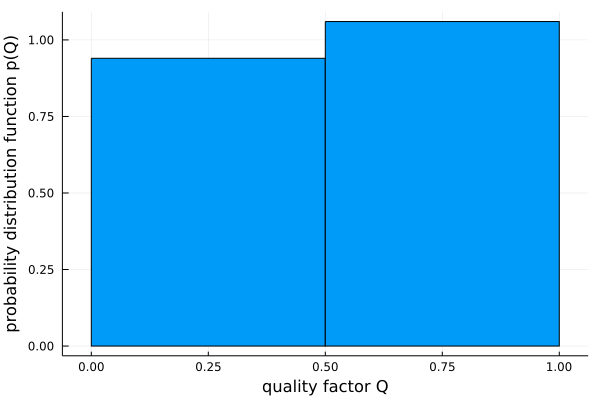

In [37]:
B_sub, X_sub = sort_trajectories(7,PX_T,B_values,mob_data)
PX_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], PX_estimates[1:2,k]) for k = 1 : 7 ]...)

println("Estimates:")
print_results(PX_estimates,PX_uncertainties)

println()

Q_sub = subpopulation_analysis(PX_T,PX_estimates,B_values,mob_data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

In [34]:
PX_estimates, PX_L, PX_T = global_EM_estimator(9,N_local,N_global,a2_range,σ2_range,B_values,mob_data);

┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ Diffus

Estimates:
a2_1 = 0.0005974246529744814 ± 5.662263053045361e-5
a2_2 = 0.0020924955643709647 ± 0.00011857833593400223
a2_3 = 0.001190771045396706 ± 0.0001098247039035612
a2_4 = 0.0024214856947633234 ± 0.00017753442128962422
a2_5 = 0.0038962742177063745 ± 0.00016866421236640114
a2_6 = 0.002816220365912036 ± 0.0001283238314073379
a2_7 = 0.0021707162720108505 ± 0.00016566891272095204
a2_8 = 0.005188583653315553 ± 0.000618432095563011
a2_9 = 0.006308176565875096 ± 0.0011685969753600345
σ2_1 = 0.0005784868384033887 ± 5.889647630813982e-5
σ2_2 = 0.0016327485042061504 ± 0.00010991013810584657
σ2_3 = 0.004252769916939452 ± 0.0002020931654240547
σ2_4 = 0.00973999908002353 ± 0.0003397540607136783
σ2_5 = 0.002300899997124626 ± 0.00013382131359547354
σ2_6 = 0.005327881226834728 ± 0.00018435658298779584
σ2_7 = 0.00037462936042299616 ± 6.185976204020669e-5
σ2_8 = 0.00028741602035144105 ± 0.00010868341584716533
σ2_9 = 0.005380487662660989 ± 0.0011366598292376952
P_1 = 0.0399999977233299
P_2 = 0.100118

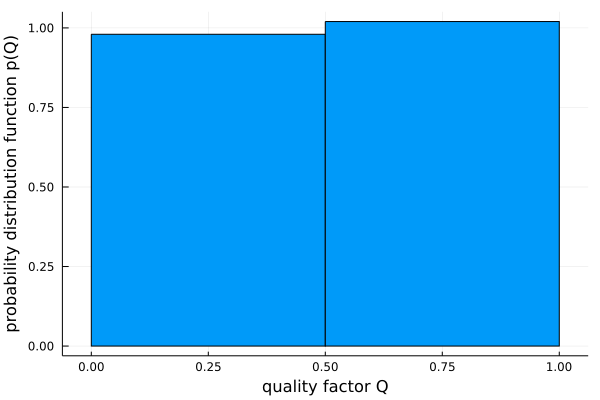

In [35]:
B_sub, X_sub = sort_trajectories(9,PX_T,B_values,mob_data)
PX_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], PX_estimates[1:2,k]) for k = 1 : 9 ]...)

println("Estimates:")
print_results(PX_estimates,PX_uncertainties)

println()

Q_sub = subpopulation_analysis(PX_T,PX_estimates,B_values,mob_data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

In [14]:
mob_data

100-element Vector{Matrix{Float64}}:
 [38.03921533198764 91.0106436419909; 38.09617753579804 91.00776183247646; … ; 38.73356399169896 90.861295747367; 38.72901413300927 90.81509502179505]
 [52.30472173254977 93.76520392993226; 52.27783483328655 93.77576881939284; … ; 52.38725756751814 93.74988630652514; 52.40265056064772 93.79039283633881]
 [58.18545736344977 26.658555290703173; 58.16101127467751 26.60920696440354; … ; 59.177916040309285 26.189248766015826; 59.17743104409828 26.11645920828872]
 [68.02567255279081 55.05453029482074; 68.00926060531117 55.06106059930411; … ; 68.26395440750933 54.695763348212175; 68.29964597964874 54.719991454406006]
 [76.20040871000602 65.1557582450138; 76.15665586216313 65.15185150840257; … ; 76.03780241668355 65.11023952818526; 76.10232926961729 65.13858765069354]
 [78.32558785296726 76.38300702927226; 78.31922156488538 76.42961738719461; … ; 76.18159321611192 76.70540175158693; 76.19345655465617 76.69502384632253]
 [78.86439042069273 89.61838701846666;

In [19]:
data[[1]]

1-element Vector{Matrix{Float64}}:
 [-0.2736163995431172 -0.1051718290530699; 0.6901288696997122 0.3147046597626799; … ; -2.347536267704408 0.055304819967828656; -2.7614535527513286 0.9422712899779128]

In [18]:
mob_data[[1]]

1-element Vector{Matrix{Float64}}:
 [38.03921533198764 91.0106436419909; 38.09617753579804 91.00776183247646; … ; 38.66832991678541 91.03632763906067; 38.671069731886114 91.02072798480471]